# Setup

In [1]:
# Installing Python libraries
!pip install pymongo==3.7.2 folium==0.9.1 geopandas==0.7.0 seaborn numpy tqdm

In [2]:
import pymongo                            # Library to access MongoDB
from pymongo import MongoClient           # Imports MongoClient 
import pandas as pd                       # Library to work with dataframes
import folium                             # Library to create the map
from folium import plugins                # plugin to create a heatmap
import seaborn as sns
import numpy as np
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
import re

In [3]:
# uri (uniform resource identifier) defines the connection parameters 
uri = 'mongodb://127.0.0.1:27017'
# start client to connect to MongoDB server 
client = MongoClient( uri )
db = client.JiraRepos

# Functions

In [15]:
def issue_map():
    """Get the custom issue mapping as a dictionary.
    """
    return dict(pd.read_csv('issue_map.csv').values)

def standardize_issue_name(name):
    """Try to standardize issue types so they can be shown in less columns.
    """
    name = name.strip()
    return issue_dict[name] if name in issue_dict else name

def lexicon_to_array():
    lexicon = pd.read_csv('Harassment Lexicon.csv')
    arr = lexicon.fillna('').astype(str).values.flatten().tolist()
    # Ditch some words here with special characters.
    return [i for i in arr if i and not re.search("[()*!?]", i)]

def lexicon_to_space_delimited():
    return " ".join(lexicon_array)

def find_all_issue_types():
    """Find all issue types so we can run multiple queries that may run different subsets, allowing for setting 0's.
    """
    all_issue_types = set()
    collections = db.list_collection_names()[:7]
    
    progress_bar = tqdm(collections)
    for name in progress_bar:
        all_issue_types.update(set([standardize_issue_name(row["_id"]) for row in query_count_by_issue_type_without_sum(db[name])]))
    return all_issue_types

def query_count_by_issue_type(collection):
    return query_aggregate([
        { "$group": { "_id": '$fields.issuetype.name', "count": {"$sum": 1} } },
    ], collection)

def query_count_by_issue_type_without_sum(collection):
    return query_aggregate([
        { "$group": { "_id": '$fields.issuetype.name'} },
    ], collection)

def query_count_by_issue_type_having_comments(collection):
     return query_aggregate([
        { "$match": { "fields.comments": { "$exists": "true", "$type": "array", "$ne": [] } } },
        { "$group": { "_id": '$fields.issuetype.name', "count": {"$sum": 1} } },
    ], collection)

def query_count_by_issue_type_having_toxic_comments(collection):
    """ (DONT USE THIS) This solution uses a regex and is very slow (also the format is fucked up due to the projection).
    """
    return query_aggregate([
        { "$project": {
            "fields.comments": {
                "$filter": {
                    "input": "$fields.comments.body",
                    "as": "varcommentbody",
                    "cond": { "$regexMatch": { "input": "$$varcommentbody", "regex": "/" + "|".join(lexicon_array) + "/", "options": "i" } },
                }
            }
        } },
        { "$match": { "fields.comments": { "$exists": "true", "$type": "array", "$ne": [] } } },
        { "$group": { "_id": '$fields.issuetype.name', "count": {"$sum": 1} } },
    ], collection)

def query_count_by_issue_type_having_toxic_comments_fts(collection):
    """Uses a full-text search.
    """
    # Create index for specific column. A collection can only have 1 text index and it is automatically the one used.
    collection.create_index([('fields.comments.body', pymongo.TEXT)], name='my_search_index', default_language='english')
    return query_aggregate([
        { "$match": { "$text": { "$search": lexicon_to_space_delimited() } } },
        { "$group": { "_id": '$fields.issuetype.name', "count": {"$sum": 1} } },
    ], collection)

def query_get_issues_with_toxic_comments(collection, limit=5):
    return list(collection.find({ "$text": { "$search": lexicon_to_space_delimited() } }).limit(limit))


def query_aggregate(query, collection):
    """ Convenience wrapper to track time.
    """
    start = time.time()
    result = list(collection.aggregate(query))
    end = time.time()
    # print("Duration: {} seconds".format(end - start))
    return result

def find_comments_per_issue(query_fn_string, issue_types):
    """This function runs a count query per issue type on each collection in our Jira database. It might take a minute or so.
    
    TODO: filter comments by toxic words (hopefully i can just edit the mongodb query to accept a list)
    
    """
    data = []
    
    collections = db.list_collection_names()
    # collections = np.array(db.list_collection_names())[:2]
    
    progress_bar = tqdm(collections)
    for name in progress_bar:
        progress_bar.set_description("Processing %s" % name)
        # Call function from string.
        result = globals()[query_fn_string](db[name])
        subdata = {};
        # Add any issue types with count data to the subdata.
        for row in result:
            issue_type = standardize_issue_name(row['_id'])
            if issue_type in subdata:
                subdata[issue_type] += row['count']
            else:
                subdata[issue_type] = row['count']
        data.append([name, subdata])
            
    # Fill in the complete matrix because issue types differ per subset.
    data2 = []
    for row in data:
        # First column = name
        subdata = [row[0]]
        for issue_type in issue_types:
            subdata.append(row[1][issue_type] if issue_type in row[1] else 0)
        data2.append(subdata)

    data2 = np.array(data2)
    # # Use first column as index, rest as the data.
    df = pd.DataFrame(np.array(data2[:,1:], dtype=np.int32), columns=list(issue_types), index=data2[:,0])   
    return df

def get_toxic_comments(collection, limit=5, colorize=True, show_comment=True):
    def red(text):
        return "\x1b[31m" + text + "\x1b[0m"
    
    lexicon_regex = "|".join(['\\b' + i + "\\b" for i in lexicon_array])
    results = query_get_issues_with_toxic_comments(collection, limit)
    comments = []
    for result in results:
        for comment in result['fields']['comments']:
            found = re.search(lexicon_regex, str(comment), re.IGNORECASE)
            if(found):
                comments.append("[FOUND: " + red(found.group()) + "] " + re.sub("\\b" + found.group() + "\\b", red(found.group()), comment['body'] if show_comment else ""))
    return comments

In [13]:
# Cache global variables to prevent reparsing:
issue_dict = issue_map()
lexicon_array = lexicon_to_array()

print("Lexicon length: {}".format(len(lexicon_array)))

Lexicon length: 698


# Execution + Results

In [6]:
all_issue_types = find_all_issue_types()
print(all_issue_types)
df_comments = find_comments_per_issue("query_count_by_issue_type_having_comments", all_issue_types)
df_toxic_comments = find_comments_per_issue("query_count_by_issue_type_having_toxic_comments_fts", all_issue_types)
print('Done')

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:09<00:00,  1.33s/it]


{'development', 'new', 'task', 'improvement', 'problem', 'documentation', 'research', 'bug', 'support', 'miscellaneous', 'request'}


Processing Jira: 100%|█████████████████████████████████████████████████████████████████| 16/16 [01:27<00:00,  5.44s/it]

Done


In [7]:
print(df_comments.shape)
print(df_toxic_comments.shape)

# Divide toxic comments by total comments to get a percentage.
df_div = df_toxic_comments.div(df_comments).fillna(0)

display(df_comments)
display(df_toxic_comments)
display(df_div)

(16, 11)
(16, 11)


,development,new,task,improvement,problem,documentation,research,bug,support,miscellaneous,request
SecondLife,0,44,231,0,948,0,295,241,0,0,0
IntelDAOS,0,0,195,0,0,0,3815,3278,0,0,0
Mojang,0,0,0,0,0,0,0,381027,0,0,0
MariaDB,0,0,0,0,0,0,0,0,0,0,0
Hyperledger,0,596,6861,520,0,333,3609,5970,0,0,0
Sonatype,0,65470,1032,1973,1594,0,167,5489,9371,0,0
Sakai,58,0,8250,5,0,0,1,29521,0,1080,5049
Qt,0,0,11319,6,0,0,2368,86955,11083,0,141
JFrog,0,665,331,940,0,5,3,3485,16,0,11
Spring,0,6294,9185,18763,269,0,1532,24959,180,0,0


,development,new,task,improvement,problem,documentation,research,bug,support,miscellaneous,request
SecondLife,0,9,40,0,297,0,126,62,0,0,0
IntelDAOS,0,0,42,0,0,0,796,1318,0,0,0
Mojang,0,0,0,0,0,0,0,66188,0,0,0
MariaDB,0,0,0,0,0,0,0,0,0,0,0
Hyperledger,0,78,720,29,0,51,536,1237,0,0,0
Sonatype,0,13025,95,330,322,0,38,1126,1183,0,0
Sakai,14,0,1897,0,0,0,0,7478,0,381,1260
Qt,0,0,1452,1,0,0,437,21743,2390,0,20
JFrog,0,115,32,122,0,1,1,694,4,0,5
Spring,0,1238,600,3007,37,0,172,5274,28,0,0


,development,new,task,improvement,problem,documentation,research,bug,support,miscellaneous,request
SecondLife,0.000000,0.204545,0.173160,0.000000,0.313291,0.000000,0.427119,0.257261,0.000000,0.000000,0.000000
IntelDAOS,0.000000,0.000000,0.215385,0.000000,0.000000,0.000000,0.208650,0.402074,0.000000,0.000000,0.000000
Mojang,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.173709,0.000000,0.000000,0.000000
MariaDB,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Hyperledger,0.000000,0.130872,0.104941,0.055769,0.000000,0.153153,0.148518,0.207203,0.000000,0.000000,0.000000
Sonatype,0.000000,0.198946,0.092054,0.167258,0.202008,0.000000,0.227545,0.205138,0.126241,0.000000,0.000000
Sakai,0.241379,0.000000,0.229939,0.000000,0.000000,0.000000,0.000000,0.253311,0.000000,0.352778,0.249554
Qt,0.000000,0.000000,0.128280,0.166667,0.000000,0.000000,0.184544,0.250049,0.215646,0.000000,0.141844
JFrog,0.000000,0.172932,0.096677,0.129787,0.000000,0.200000,0.333333,0.199139,0.250000,0.000000,0.454545
Spring,0.000000,0.196695,0.065324,0.160262,0.137546,0.000000,0.112272,0.211307,0.155556,0.000000,0.000000


In [29]:
def draw_heatmap(data, title, xlabel, ylabel, fmt='d'):
    ax = plt.axes()
    sns.heatmap(data, annot=True, square=True, fmt=fmt)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout()
    # plt.savefig('heatmap.svg')
    plt.show()
    pass

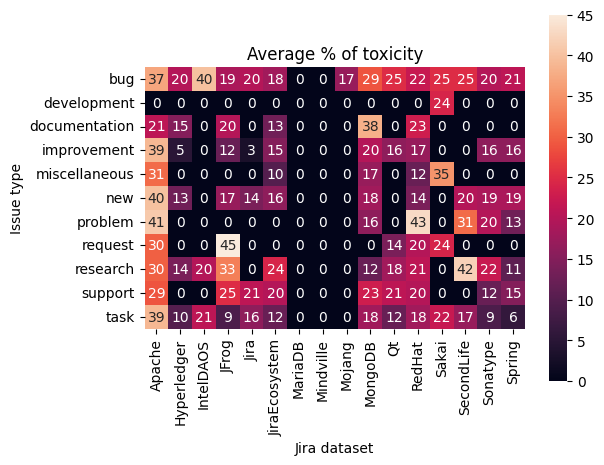

In [30]:
draw_heatmap(df_div.multiply(100).astype(int).sort_index(axis=0).sort_index(axis=1).T, 'Average % of toxicity', 'Jira dataset', 'Issue type')

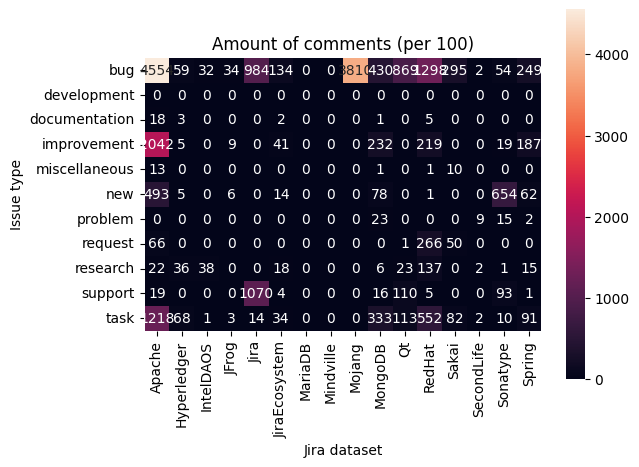

In [10]:
draw_heatmap(df_comments.divide(100).astype(int).sort_index(axis=0).sort_index(axis=1).T, 'Amount of comments (per 100)', 'Jira dataset', 'Issue type')

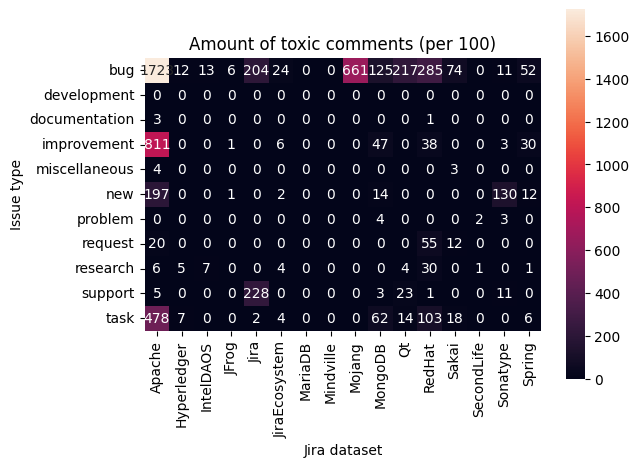

In [11]:
draw_heatmap(df_toxic_comments.divide(100).astype(int).sort_index(axis=0).sort_index(axis=1).T, 'Amount of toxic comments (per 100)', 'Jira dataset', 'Issue type')

In [16]:
for name in db.list_collection_names():
    comments = get_toxic_comments(db[name], limit=5, colorize=True, show_comment=False)
    print("Comments for '" + name + '"')
    for comment in comments:
        print(comment)

Comments for 'SecondLife"
[FOUND: moron] 
[FOUND: arse] 
[FOUND: butt] 
[FOUND: butt] 
[FOUND: moron] 
[FOUND: butt] 
[FOUND: dumb] 
[FOUND: pos] 
[FOUND: baby] 
[FOUND: nude] 
Comments for 'IntelDAOS"
Comments for 'Mojang"
[FOUND: Arab] 
Comments for 'MariaDB"
Comments for 'Hyperledger"
Comments for 'Sonatype"
[FOUND: suck] 
Comments for 'Sakai"
Comments for 'Qt"
[FOUND: anal] 
Comments for 'JFrog"
[FOUND: asses] 
Comments for 'Spring"
[FOUND: aroused] 
Comments for 'MongoDB"
Comments for 'Apache"
Comments for 'Mindville"
Comments for 'RedHat"
[FOUND: indian] 
[FOUND: anal] 
[FOUND: anal] 
Comments for 'JiraEcosystem"
[FOUND: arse] 
[FOUND: suck] 
[FOUND: arse] 
[FOUND: arse] 
Comments for 'Jira"
[FOUND: anal] 
